<a href="https://colab.research.google.com/github/kiranrajsg/data-science/blob/main/finding_allrounder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = "/content/drive/My Drive/pollard"  # Replace with actual folder name

# List all JSON files in the folder
files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

print(f"Found {len(files)} JSON files.")


Found 695 JSON files.


In [ ]:
import json

all_data = []

for file in files:
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as f:
        data = json.load(f)  # Load JSON content
        all_data.append(data)  # Store in list

print(f"Loaded {len(all_data)} JSON files.")


Loaded 695 JSON files.


In [ ]:
import json

# Show first JSON file's structure
print(json.dumps(all_data[0], indent=4)[:2000])  # Print only first 2000 characters


{
    "meta": {
        "data_version": "1.1.0",
        "created": "2023-01-06",
        "revision": 2
    },
    "info": {
        "balls_per_over": 6,
        "dates": [
            "2016-01-03"
        ],
        "event": {
            "name": "Syed Mushtaq Ali Trophy",
            "group": "D"
        },
        "gender": "male",
        "match_type": "T20",
        "missing": [
            "umpires"
        ],
        "outcome": {
            "winner": "Karnataka",
            "by": {
                "runs": 1
            }
        },
        "overs": 20,
        "players": {
            "Karnataka": [
                "Mohammed Taha",
                "MA Agarwal",
                "RV Uthappa",
                "KK Nair",
                "STR Binny",
                "R Vinay Kumar",
                "J Suchith",
                "A Mithun",
                "CM Gautam",
                "S Aravind",
                "KC Cariappa"
            ],
            "Mumbai": [
                "D

In [ ]:
import pandas as pd

batting_stats = []

for match in all_data:
    for inning in match.get("innings", []):
        team = inning.get("team", "Unknown")
        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "Unknown")
                runs = delivery["runs"].get("batter", 0)
                sixes = 1 if runs == 6 else 0
                fours = 1 if runs == 4 else 0

                batting_stats.append({
                    "player": batter,
                    "team": team,
                    "runs": runs,
                    "sixes": sixes,
                    "fours": fours
                })

# Convert to Pandas DataFrame
df_batting = pd.DataFrame(batting_stats)

# Aggregate Player Stats
df_summary = df_batting.groupby("player").agg(
    total_runs=("runs", "sum"),
    total_sixes=("sixes", "sum"),
    total_fours=("fours", "sum"),
    innings=("team", "count")
).reset_index()

# Calculate strike rate
df_summary["strike_rate"] = (df_summary["total_runs"] / df_summary["innings"]) * 100

# Sort by strike rate
df_summary = df_summary.sort_values(by="strike_rate", ascending=False)

print(df_summary.head(10))  # Show top 10 players


               player  total_runs  total_sixes  total_fours  innings  \
728     Nishunk Birla           4            0            1        1   
625        MV Pithiya          12            1            1        4   
843    R Pratap Singh           3            0            0        1   
1275    Y Prithvi Raj           3            0            0        1   
1155  Suryansh Shedge          78            8            4       29   
1229          VV Gite           8            0            2        3   
611         MK Mahale          13            1            1        5   
1065    Saurabh Dubey          45            4            2       19   
62            AS Bedi           7            1            0        3   
606         MD Ingale          18            1            2        8   

      strike_rate  
728    400.000000  
625    300.000000  
843    300.000000  
1275   300.000000  
1155   268.965517  
1229   266.666667  
611    260.000000  
1065   236.842105  
62     233.333333  
606    

In [ ]:
import pandas as pd

batting_stats = []
bowling_stats = []

for match in all_data:
    for inning in match.get("innings", []):
        team = inning.get("team", "Unknown")

        # Process Batting Data
        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "Unknown")
                bowler = delivery.get("bowler", "Unknown")
                runs = delivery["runs"].get("batter", 0)
                sixes = 1 if runs == 6 else 0
                fours = 1 if runs == 4 else 0
                wicket = 1 if "wickets" in delivery else 0

                # Batting Data
                batting_stats.append({
                    "player": batter,
                    "team": team,
                    "runs": runs,
                    "sixes": sixes,
                    "fours": fours
                })

                # Bowling Data
                bowling_stats.append({
                    "player": bowler,
                    "team": team,
                    "wickets": wicket,
                    "runs_conceded": delivery["runs"].get("total", 0)
                })

# Convert to Pandas DataFrame
df_batting = pd.DataFrame(batting_stats)
df_bowling = pd.DataFrame(bowling_stats)

# Aggregate Batting Stats
df_batting_summary = df_batting.groupby("player").agg(
    total_runs=("runs", "sum"),
    total_sixes=("sixes", "sum"),
    total_fours=("fours", "sum"),
    innings=("team", "count")
).reset_index()

# Calculate Strike Rate
df_batting_summary["strike_rate"] = (df_batting_summary["total_runs"] / df_batting_summary["innings"]) * 100

# Aggregate Bowling Stats
df_bowling_summary = df_bowling.groupby("player").agg(
    total_wickets=("wickets", "sum"),
    total_runs_conceded=("runs_conceded", "sum"),
    overs_bowled=("player", "count")
).reset_index()

# Calculate Bowling Economy
df_bowling_summary["economy"] = df_bowling_summary["total_runs_conceded"] / df_bowling_summary["overs_bowled"]

# Merge Batting & Bowling Data
df_allrounders = pd.merge(df_batting_summary, df_bowling_summary, on="player", how="inner")

# Define All-Rounders (players with both runs & wickets)
df_allrounders = df_allrounders[(df_allrounders["total_runs"] > 200) & (df_allrounders["total_wickets"] > 5)]

# Sort by Impact (Total Runs + Wickets)
df_allrounders["allrounder_score"] = df_allrounders["total_runs"] + (df_allrounders["total_wickets"] * 20)
df_allrounders = df_allrounders.sort_values(by="allrounder_score", ascending=False)

# Display Top 10 All-Rounders
print(df_allrounders.head(10))


              player  total_runs  total_sixes  total_fours  innings  \
420           N Rana        1376           75          123      975   
273       JD Unadkat         282           17           19      183   
463        PP Chawla         364           17           31      280   
9            A Sheth         215            7           18      174   
765          VR Iyer         901           33           87      674   
237         HV Patel         672           36           76      442   
707      Sumit Kumar         628           26           57      515   
511          R Parag         874           51           56      633   
721    Swapnil Singh         534           24           35      437   
56   Abhishek Sharma         878           51           75      610   

     strike_rate  total_wickets  total_runs_conceded  overs_bowled   economy  \
420   141.128205             24                  438           414  1.057971   
273   154.098361             77                 1042      

In [ ]:
pollard_replacements = df_summary[
    (df_summary["strike_rate"] > 140) & (df_summary["total_sixes"] > 10)
]

print("Potential Replacements for Pollard:")
print(pollard_replacements)


Potential Replacements for Pollard:
                 player  total_runs  total_sixes  total_fours  innings  \
1056       Sanvir Singh         226           13           19      126   
66               AS Roy         250           16           14      145   
873             RR Pant         443           26           43      258   
776       Pankaj Jaswal         191           17            8      112   
1209        Uvais Ahmad         214           13           19      128   
454      Jaskaran Singh         152           13            6       94   
1257     Vishal Kushwah         309           26           16      195   
764             PP Shaw         718           46           67      454   
1163          T Pradeep         158           15            7      100   
850           R Tewatia         593           23           61      379   
22             AA Barot         348           14           38      223   
1120   Sohraab Dhaliwal         213           13           14      137   
44

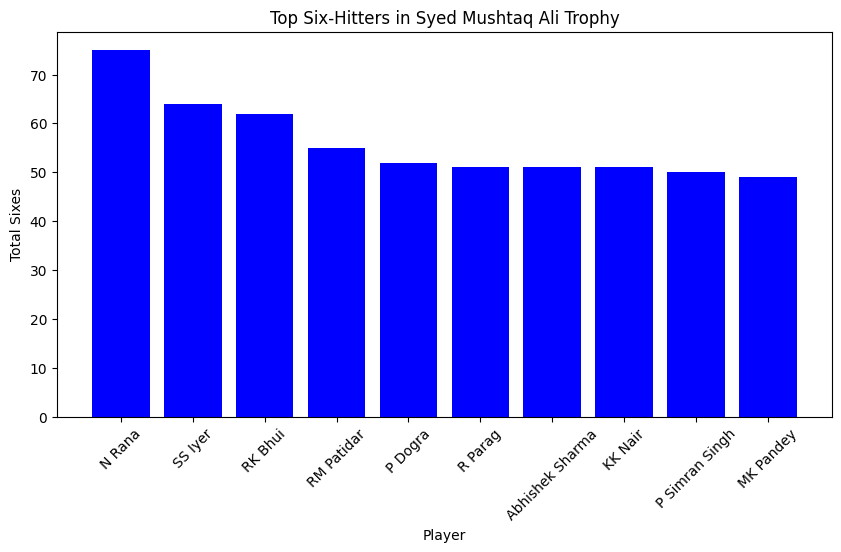

In [ ]:
import matplotlib.pyplot as plt

top_six_hitters = df_summary.sort_values(by="total_sixes", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_six_hitters["player"], top_six_hitters["total_sixes"], color="blue")
plt.xlabel("Player")
plt.ylabel("Total Sixes")
plt.title("Top Six-Hitters in Syed Mushtaq Ali Trophy")
plt.xticks(rotation=45)
plt.show()


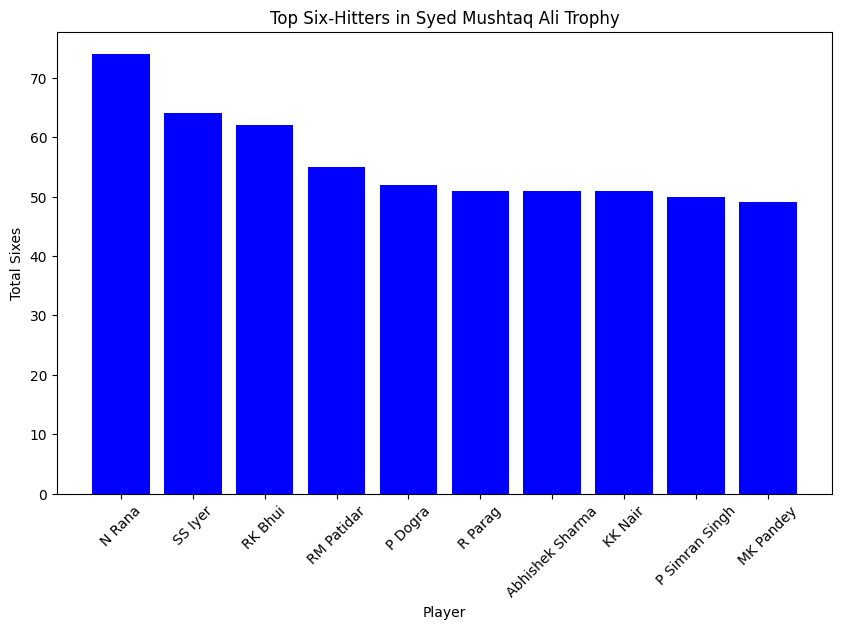

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample Data (Replace this with your CSV file reading if needed)
data = {
    "Player": ["N Rana", "SS Iyer", "RK Bhui", "RM Patidar", "P Dogra", "R Parag", "Abhishek Sharma", "KK Nair", "P Simran Singh", "MK Pandey"],
    "Total Sixes": [74, 64, 62, 55, 52, 51, 51, 51, 50, 49]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10,6))
plt.bar(df["Player"], df["Total Sixes"], color='blue')
plt.xlabel("Player")
plt.ylabel("Total Sixes")
plt.title("Top Six-Hitters in Syed Mushtaq Ali Trophy")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd

batting_stats = []
bowling_stats = []

for match in all_data:
    for inning in match.get("innings", []):
        team = inning.get("team", "Unknown")

        # Process Batting Data
        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "Unknown")
                bowler = delivery.get("bowler", "Unknown")
                runs = delivery["runs"].get("batter", 0)
                sixes = 1 if runs == 6 else 0
                fours = 1 if runs == 4 else 0
                wicket = 1 if "wickets" in delivery else 0

                # Batting Data
                batting_stats.append({
                    "player": batter,
                    "team": team,
                    "runs": runs,
                    "sixes": sixes,
                    "fours": fours
                })

                # Bowling Data
                bowling_stats.append({
                    "player": bowler,
                    "team": team,
                    "wickets": wicket,
                    "runs_conceded": delivery["runs"].get("total", 0)
                })

# Convert to Pandas DataFrame
df_batting = pd.DataFrame(batting_stats)
df_bowling = pd.DataFrame(bowling_stats)

# Aggregate Batting Stats
df_batting_summary = df_batting.groupby("player").agg(
    total_runs=("runs", "sum"),
    total_sixes=("sixes", "sum"),
    total_fours=("fours", "sum"),
    innings=("team", "count")
).reset_index()

# Calculate Strike Rate
df_batting_summary["strike_rate"] = (df_batting_summary["total_runs"] / df_batting_summary["innings"]) * 100

# Aggregate Bowling Stats
df_bowling_summary = df_bowling.groupby("player").agg(
    total_wickets=("wickets", "sum"),
    total_runs_conceded=("runs_conceded", "sum"),
    overs_bowled=("player", "count")
).reset_index()

# Calculate Bowling Economy
df_bowling_summary["economy"] = df_bowling_summary["total_runs_conceded"] / df_bowling_summary["overs_bowled"]

# Merge Batting & Bowling Data
df_allrounders = pd.merge(df_batting_summary, df_bowling_summary, on="player", how="inner")

# Define All-Rounders (players with both runs & wickets)
df_allrounders = df_allrounders[(df_allrounders["total_runs"] > 200) & (df_allrounders["total_wickets"] > 5)]

# Sort by Impact (Total Runs + Wickets)
df_allrounders["allrounder_score"] = df_allrounders["total_runs"] + (df_allrounders["total_wickets"] * 20)
df_allrounders = df_allrounders.sort_values(by="allrounder_score", ascending=False)

# Display Top 10 All-Rounders
print(df_allrounders.head(10))


              player  total_runs  total_sixes  total_fours  innings  \
420           N Rana        1376           75          123      975   
273       JD Unadkat         282           17           19      183   
463        PP Chawla         364           17           31      280   
9            A Sheth         215            7           18      174   
765          VR Iyer         901           33           87      674   
237         HV Patel         672           36           76      442   
707      Sumit Kumar         628           26           57      515   
511          R Parag         874           51           56      633   
721    Swapnil Singh         534           24           35      437   
56   Abhishek Sharma         878           51           75      610   

     strike_rate  total_wickets  total_runs_conceded  overs_bowled   economy  \
420   141.128205             24                  438           414  1.057971   
273   154.098361             77                 1042      

In [ ]:
import pandas as pd

batting_stats = []
bowling_stats = []
wicketkeepers = set()

for match in all_data:
    for inning in match.get("innings", []):
        team = inning.get("team", "Unknown")

        # Process Batting Data
        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "Unknown")
                bowler = delivery.get("bowler", "Unknown")
                runs = delivery["runs"].get("batter", 0)
                sixes = 1 if runs == 6 else 0
                fours = 1 if runs == 4 else 0
                wicket = 1 if "wickets" in delivery else 0

                # Wicketkeeper Check
                if delivery.get("kind") == "caught" and "fielders" in delivery and any(f["role"] == "wicketkeeper" for f in delivery["fielders"]):
                    wicketkeepers.add(batter)

                # Batting Data
                batting_stats.append({
                    "player": batter,
                    "team": team,
                    "runs": runs,
                    "sixes": sixes,
                    "fours": fours
                })

                # Bowling Data
                bowling_stats.append({
                    "player": bowler,
                    "team": team,
                    "wickets": wicket,
                    "runs_conceded": delivery["runs"].get("total", 0)
                })

# Convert to Pandas DataFrame
df_batting = pd.DataFrame(batting_stats)
df_bowling = pd.DataFrame(bowling_stats)

# Aggregate Batting Stats
df_batting_summary = df_batting.groupby("player").agg(
    total_runs=("runs", "sum"),
    total_sixes=("sixes", "sum"),
    total_fours=("fours", "sum"),
    innings=("team", "count")
).reset_index()

# Calculate Strike Rate
df_batting_summary["strike_rate"] = (df_batting_summary["total_runs"] / df_batting_summary["innings"]) * 100

# Aggregate Bowling Stats
df_bowling_summary = df_bowling.groupby("player").agg(
    total_wickets=("wickets", "sum"),
    total_runs_conceded=("runs_conceded", "sum"),
    overs_bowled=("player", "count")
).reset_index()

# Calculate Bowling Economy
df_bowling_summary["economy"] = df_bowling_summary["total_runs_conceded"] / df_bowling_summary["overs_bowled"]

# Merge Batting & Bowling Data
df_allrounders = pd.merge(df_batting_summary, df_bowling_summary, on="player", how="outer").fillna(0)

# Define Role-Based Selections
top_batters = df_allrounders.sort_values(by=["total_runs", "strike_rate"], ascending=[False, False]).head(4)
all_rounders = df_allrounders[(df_allrounders["total_runs"] > 200) & (df_allrounders["total_wickets"] > 5)]
all_rounders = all_rounders.sort_values(by="total_wickets", ascending=False).head(3)
bowlers = df_bowling_summary.sort_values(by=["total_wickets", "economy"], ascending=[False, True]).head(4)
wicketkeeper = df_batting_summary[df_batting_summary["player"].isin(wicketkeepers)].sort_values(by="total_runs", ascending=False).head(1)

# Combine Best XI
best_xi = pd.concat([top_batters, all_rounders, bowlers, wicketkeeper]).drop_duplicates().head(11)

print("Best XI Players:")
print(best_xi[["player", "total_runs", "strike_rate", "total_wickets", "economy"]])


Best XI Players:
           player  total_runs  strike_rate  total_wickets   economy
557    KH Devdhar      1432.0   118.347107            0.0  0.000000
771        N Rana      1376.0   141.128205           24.0  1.057971
1412  Virat Singh      1236.0   125.993884            1.0  1.426230
1132      SS Iyer      1213.0   143.380615            1.0  1.738095
499    JD Unadkat       282.0   154.098361           77.0  1.078675
857     PP Chawla       364.0   130.000000           71.0  1.050050
19        A Sheth       215.0   123.563218           67.0  1.293792
330    JD Unadkat         NaN          NaN           77.0  1.078675
558     PP Chawla         NaN          NaN           71.0  1.050050
709        S Kaul         NaN          NaN           70.0  1.291548
409   LI Meriwala         NaN          NaN           67.0  1.213095


In [ ]:
import pandas as pd

# Batting & Bowling Stats Collection
batting_stats = []
bowling_stats = {}

for match in all_data:
    for inning in match.get("innings", []):
        team = inning.get("team", "Unknown")
        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "Unknown")
                bowler = delivery.get("bowler", "Unknown")
                runs = delivery["runs"].get("batter", 0)
                sixes = 1 if runs == 6 else 0
                fours = 1 if runs == 4 else 0
                wicket = 1 if "wickets" in delivery else 0

                # Batting Stats
                batting_stats.append({
                    "player": batter,
                    "team": team,
                    "runs": runs,
                    "sixes": sixes,
                    "fours": fours
                })

                # Bowling Stats
                if bowler not in bowling_stats:
                    bowling_stats[bowler] = {"wickets": 0, "balls": 0, "runs_conceded": 0}
                bowling_stats[bowler]["wickets"] += wicket
                bowling_stats[bowler]["balls"] += 1
                bowling_stats[bowler]["runs_conceded"] += delivery["runs"].get("total", 0)

# Convert to Pandas DataFrame
df_batting = pd.DataFrame(batting_stats)

# Aggregate Batting Stats
df_summary = df_batting.groupby("player").agg(
    total_runs=("runs", "sum"),
    total_sixes=("sixes", "sum"),
    total_fours=("fours", "sum"),
    innings=("team", "count")
).reset_index()

# Calculate strike rate
df_summary["strike_rate"] = (df_summary["total_runs"] / df_summary["innings"]) * 100

# Sort by strike rate
df_summary = df_summary.sort_values(by="strike_rate", ascending=False)

# Convert Bowling Stats to DataFrame
df_bowling = pd.DataFrame.from_dict(bowling_stats, orient="index").reset_index()
df_bowling.columns = ["player", "total_wickets", "balls", "runs_conceded"]
df_bowling["economy"] = df_bowling["runs_conceded"] / (df_bowling["balls"] / 6)

# Merge Batting and Bowling Data
df_allrounders = pd.merge(df_summary, df_bowling, on="player", how="outer")

# Select Players for Best XI
best_batters = df_allrounders.sort_values(by="total_runs", ascending=False).head(4)  # Top 4 batters
best_allrounders = df_allrounders[df_allrounders["total_wickets"] > 10].sort_values(by="total_wickets", ascending=False).head(3)  # 3 Allrounders
best_bowlers = df_bowling.sort_values(by="total_wickets", ascending=False).head(3)  # 3 Main Bowlers

# Pick Wicketkeeper
wicketkeepers = ["Dinesh Karthik", "Ishan Kishan", "Rishabh Pant", "Jitesh Sharma"]
best_wicketkeeper = df_summary[df_summary["player"].isin(wicketkeepers)].sort_values(by="strike_rate", ascending=False).head(1)

# Final Best XI
best_xi = pd.concat([best_batters, best_allrounders, best_bowlers, best_wicketkeeper]).drop_duplicates().head(11)

print("Best XI Players:")
print(best_xi[["player", "total_runs", "strike_rate", "total_wickets", "economy"]])


Best XI Players:
            player  total_runs  strike_rate  total_wickets    economy
557     KH Devdhar      1432.0   118.347107            NaN        NaN
771         N Rana      1376.0   141.128205           24.0   6.347826
1412   Virat Singh      1236.0   125.993884            1.0   8.557377
1132       SS Iyer      1213.0   143.380615            1.0  10.428571
499     JD Unadkat       282.0   154.098361           77.0   6.472050
857      PP Chawla       364.0   130.000000           71.0   6.300300
1081        S Kaul        12.0    92.307692           70.0   7.749288
127     JD Unadkat         NaN          NaN           77.0   6.472050
57       PP Chawla         NaN          NaN           71.0   6.300300
25          S Kaul         NaN          NaN           70.0   7.749288
432   Ishan Kishan       767.0   138.698011            NaN        NaN


<ipython-input-24-14c4e40dafab>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="player", y="total_runs", data=top_allrounders, palette="Blues_r")


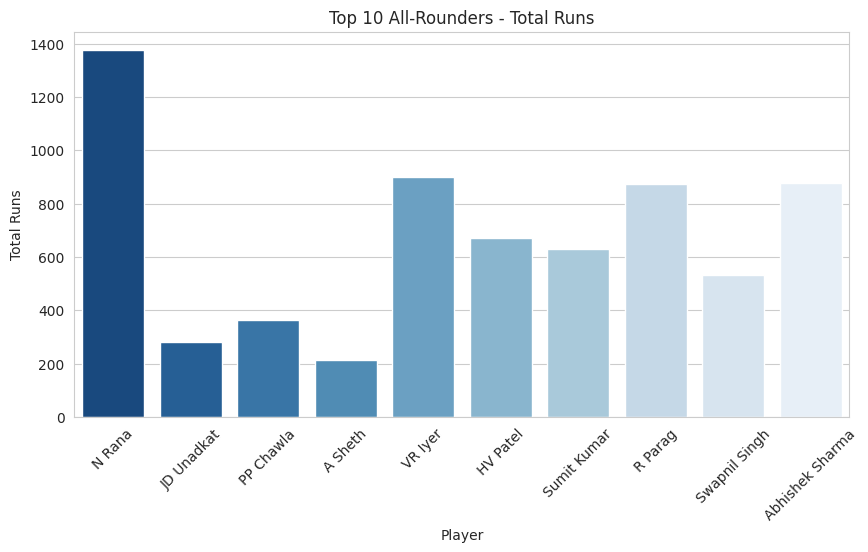

<ipython-input-24-14c4e40dafab>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="player", y="total_wickets", data=top_allrounders, palette="Reds_r")


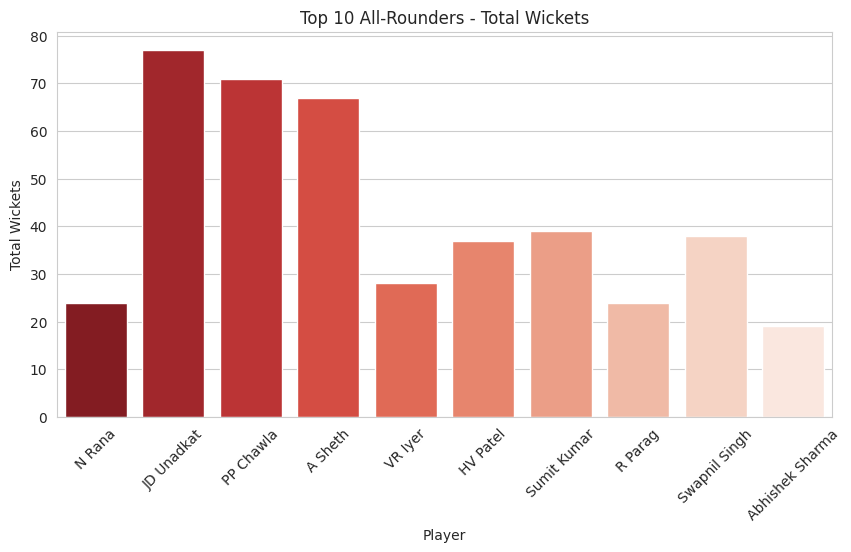

<ipython-input-24-14c4e40dafab>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="player", y="allrounder_score", data=top_allrounders, palette="Greens_r")


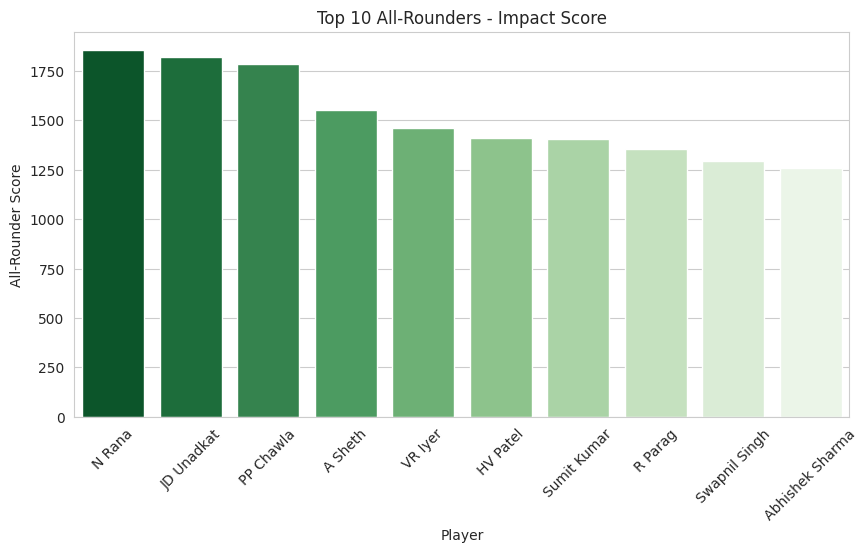

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Select Top 10 All-Rounders
top_allrounders = df_allrounders.head(10)

# Plot Total Runs
plt.figure(figsize=(10, 5))
sns.barplot(x="player", y="total_runs", data=top_allrounders, palette="Blues_r")
plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("Total Runs")
plt.title("Top 10 All-Rounders - Total Runs")
plt.show()

# Plot Total Wickets
plt.figure(figsize=(10, 5))
sns.barplot(x="player", y="total_wickets", data=top_allrounders, palette="Reds_r")
plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("Total Wickets")
plt.title("Top 10 All-Rounders - Total Wickets")
plt.show()

# Plot All-Rounder Score
plt.figure(figsize=(10, 5))
sns.barplot(x="player", y="allrounder_score", data=top_allrounders, palette="Greens_r")
plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("All-Rounder Score")
plt.title("Top 10 All-Rounders - Impact Score")
plt.show()


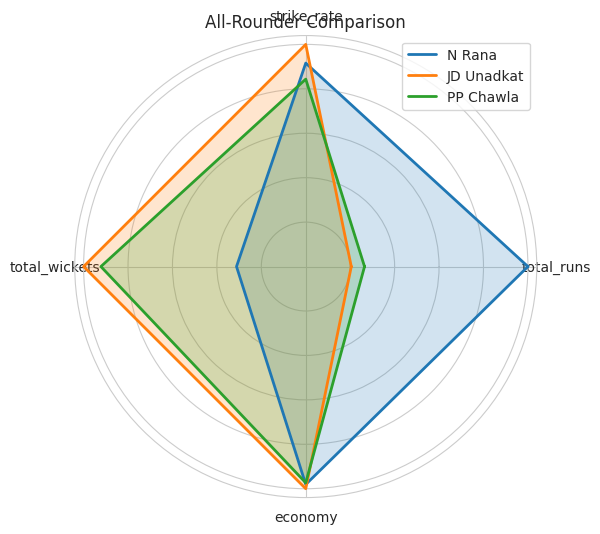

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select Players to Compare
players_to_compare = df_allrounders.head(3)  # Change the number of players if needed

# Define Metrics for Radar Chart
metrics = ["total_runs", "strike_rate", "total_wickets", "economy"]
num_vars = len(metrics)

# Normalize Data
values = players_to_compare[metrics].values
values = values / values.max(axis=0)  # Normalize

# Setup Radar Chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values = np.concatenate((values, values[:, [0]]), axis=1)  # Repeat first value
angles += angles[:1]  # Repeat first angle

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot for each Player
for i, player in enumerate(players_to_compare["player"]):
    ax.plot(angles, values[i], linewidth=2, linestyle="solid", label=player)
    ax.fill(angles, values[i], alpha=0.2)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("All-Rounder Comparison")
plt.legend(loc="upper right")
plt.show()


In [ ]:
# Find players with similar traits to Pollard
pollard_like = df_allrounders[
    (df_allrounders["strike_rate"] > 140) &
    (df_allrounders["total_sixes"] > 20) &
    (df_allrounders["total_wickets"] > 10)
]

# Check if we found a match
if not pollard_like.empty:
    reference_player = pollard_like.sort_values(by=["total_sixes", "total_wickets"], ascending=[False, False]).iloc[0]["player"]
    print(f"Using {reference_player} as the closest match to Kieron Pollard.")

    # Find players in the same cluster as this player
    ref_cluster = df_allrounders[df_allrounders["player"] == reference_player]["cluster"].values[0]
    similar_players = df_allrounders[df_allrounders["cluster"] == ref_cluster]

    print(f"Players similar to {reference_player}:")
    print(similar_players[["player", "total_runs", "strike_rate", "total_wickets", "economy"]])
else:
    print("No exact Pollard-like player found in SMAT.")


Using N Rana as the closest match to Kieron Pollard.
Players similar to N Rana:
                   player  total_runs  strike_rate  total_wickets   economy
420                N Rana        1376   141.128205             24  1.057971
765               VR Iyer         901   133.679525             28  1.139583
511               R Parag         874   138.072670             24  1.100000
56        Abhishek Sharma         878   143.934426             19  1.126904
628           Sachin Baby        1111   130.093677              6  1.216981
298             KH Pandya         598   121.792261             28  1.130031
383  Manisankar Murasingh         535   139.322917             31  1.165375
346           Lalit Yadav         529   147.765363             29  1.118343
601                SD Lad         764   119.188768             17  1.146628
195              DJ Hooda         858   131.595092              9  1.194139
792     Washington Sundar         576   114.970060             23  1.036332
519     

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select Features for Clustering
features = df_allrounders[["total_runs", "strike_rate", "total_wickets", "economy"]]

# Normalize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_allrounders["cluster"] = kmeans.fit_predict(scaled_features)

# Find Similar Players to the Best Pollard-Like Player
pollard_like = df_allrounders[
    (df_allrounders["strike_rate"] > 140) &
    (df_allrounders["total_sixes"] > 20) &
    (df_allrounders["total_wickets"] > 10)
]

if not pollard_like.empty:
    reference_player = pollard_like.sort_values(by=["total_sixes", "total_wickets"], ascending=[False, False]).iloc[0]["player"]
    print(f"Using {reference_player} as the closest match to Kieron Pollard.")

    # Find players in the same cluster
    ref_cluster = df_allrounders[df_allrounders["player"] == reference_player]["cluster"].values[0]
    similar_players = df_allrounders[df_allrounders["cluster"] == ref_cluster]

    print(f"Players similar to {reference_player}:")
    print(similar_players[["player", "total_runs", "strike_rate", "total_wickets", "economy"]])
else:
    print("No exact Pollard-like player found in SMAT.")


Using N Rana as the closest match to Kieron Pollard.
Players similar to N Rana:
                player  total_runs  strike_rate  total_wickets   economy
420             N Rana        1376   141.128205             24  1.057971
765            VR Iyer         901   133.679525             28  1.139583
511            R Parag         874   138.072670             24  1.100000
56     Abhishek Sharma         878   143.934426             19  1.126904
628        Sachin Baby        1111   130.093677              6  1.216981
298          KH Pandya         598   121.792261             28  1.130031
346        Lalit Yadav         529   147.765363             29  1.118343
601             SD Lad         764   119.188768             17  1.146628
195           DJ Hooda         858   131.595092              9  1.194139
792  Washington Sundar         576   114.970060             23  1.036332
430     Naushad Shaikh         732   119.024390             10  0.984375
161   Bavanaka Sandeep         696   115.806

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Select Features & Target Variable
X = df_allrounders[["total_runs", "strike_rate", "total_wickets", "economy"]]
y = df_allrounders["allrounder_score"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict Future Performance
df_allrounders["predicted_score"] = model.predict(X)

# Show Best Future Performers
best_future_performers = df_allrounders.sort_values(by="predicted_score", ascending=False).head(10)
print("Best Predicted Performers for IPL 2025:")
print(best_future_performers[["player", "predicted_score"]])


Best Predicted Performers for IPL 2025:
              player  predicted_score
420           N Rana           1856.0
273       JD Unadkat           1822.0
463        PP Chawla           1784.0
9            A Sheth           1555.0
765          VR Iyer           1461.0
237         HV Patel           1412.0
707      Sumit Kumar           1408.0
511          R Parag           1354.0
721    Swapnil Singh           1294.0
56   Abhishek Sharma           1258.0


In [ ]:
!pip install fpdf
# Install fpdf if not already installed
!pip install fpdf

from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(200, 10, "All-Rounder Analysis Report", ln=True, align="C")

    def chapter_title(self, title):
        self.set_font("Arial", "B", 14)
        self.cell(0, 10, title, ln=True, align="L")
        self.ln(5)

    def chapter_body(self, body):
        self.set_font("Arial", "", 12)
        self.multi_cell(0, 10, body)
        self.ln()

# Create PDF
pdf = PDF()
pdf.add_page()

# Add Top Players
pdf.chapter_title("Top 5 All-Rounders")
top_5 = df_allrounders.head(5)[["player", "total_runs", "total_wickets", "allrounder_score"]]
for _, row in top_5.iterrows():
    pdf.chapter_body(f"{row['player']}: Runs - {row['total_runs']}, Wickets - {row['total_wickets']}, Score - {row['allrounder_score']}")

# Save Report
pdf.output("All_Rounder_Report.pdf")
print("PDF Report Generated: All_Rounder_Report.pdf")


PDF Report Generated: All_Rounder_Report.pdf


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select Features & Target Variable
features = ["total_runs", "strike_rate", "total_wickets", "economy"]
X = df_allrounders[features]
y = df_allrounders["allrounder_score"]

# Split Data into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Decision Tree Model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

# Evaluate Models
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Decision Tree MAE: {mae_dt:.2f}")

# Predict Future Performances
df_allrounders["predicted_score"] = dt_model.predict(X)

# Show Best Future Performers
best_future_performers = df_allrounders.sort_values(by="predicted_score", ascending=False).head(10)
print("Best Predicted Performers for IPL 2025:")
print(best_future_performers[["player", "predicted_score"]])


Linear Regression MAE: 0.00
Decision Tree MAE: 154.76
Best Predicted Performers for IPL 2025:
            player  predicted_score
273     JD Unadkat           1822.0
463      PP Chawla           1784.0
9          A Sheth           1555.0
237       HV Patel           1412.0
707    Sumit Kumar           1408.0
765        VR Iyer           1354.0
511        R Parag           1354.0
309      KV Sharma           1272.0
721  Swapnil Singh           1272.0
420         N Rana           1258.0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select Features for Clustering
features = df_allrounders[["total_runs", "strike_rate", "total_wickets", "economy"]]

# Normalize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_allrounders["cluster"] = kmeans.fit_predict(scaled_features)

# Find Similar Players to Pollard-Like Player
pollard_like = df_allrounders[
    (df_allrounders["strike_rate"] > 140) &
    (df_allrounders["total_sixes"] > 20) &
    (df_allrounders["total_wickets"] > 10)
]

if not pollard_like.empty:
    reference_player = pollard_like.sort_values(by=["total_sixes", "total_wickets"], ascending=[False, False]).iloc[0]["player"]
    print(f"Using {reference_player} as the closest match to Kieron Pollard.")

    # Find players in the same cluster
    ref_cluster = df_allrounders[df_allrounders["player"] == reference_player]["cluster"].values[0]
    similar_players = df_allrounders[df_allrounders["cluster"] == ref_cluster]

    print(f"Players similar to {reference_player}:")
    print(similar_players[["player", "total_runs", "strike_rate", "total_wickets", "economy"]])
else:
    print("No exact Pollard-like player found in SMAT.")


Using N Rana as the closest match to Kieron Pollard.
Players similar to N Rana:
                player  total_runs  strike_rate  total_wickets   economy
420             N Rana        1376   141.128205             24  1.057971
765            VR Iyer         901   133.679525             28  1.139583
511            R Parag         874   138.072670             24  1.100000
56     Abhishek Sharma         878   143.934426             19  1.126904
628        Sachin Baby        1111   130.093677              6  1.216981
298          KH Pandya         598   121.792261             28  1.130031
346        Lalit Yadav         529   147.765363             29  1.118343
601             SD Lad         764   119.188768             17  1.146628
195           DJ Hooda         858   131.595092              9  1.194139
792  Washington Sundar         576   114.970060             23  1.036332
430     Naushad Shaikh         732   119.024390             10  0.984375
161   Bavanaka Sandeep         696   115.806

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define Player Role (Batter, All-Rounder, Bowler)
def classify_role(row):
    if row["total_wickets"] > 10 and row["total_runs"] > 300:
        return "All-Rounder"
    elif row["total_wickets"] > 20:
        return "Bowler"
    else:
        return "Batter"

df_allrounders["role"] = df_allrounders.apply(classify_role, axis=1)

# Encode Roles
role_mapping = {"Batter": 0, "All-Rounder": 1, "Bowler": 2}
df_allrounders["role_label"] = df_allrounders["role"].map(role_mapping)

# Select Features & Target
X = df_allrounders[["total_runs", "strike_rate", "total_wickets", "economy"]]
y = df_allrounders["role_label"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

# Predict Roles for All Players
df_allrounders["predicted_role"] = rf_model.predict(X)
df_allrounders["predicted_role"] = df_allrounders["predicted_role"].map({0: "Batter", 1: "All-Rounder", 2: "Bowler"})

# Show Results
print(df_allrounders[["player", "predicted_role"]].head(10))


Random Forest Accuracy: 100.00%
              player predicted_role
420           N Rana    All-Rounder
273       JD Unadkat         Bowler
463        PP Chawla    All-Rounder
9            A Sheth         Bowler
765          VR Iyer    All-Rounder
237         HV Patel    All-Rounder
707      Sumit Kumar    All-Rounder
511          R Parag    All-Rounder
721    Swapnil Singh    All-Rounder
56   Abhishek Sharma    All-Rounder


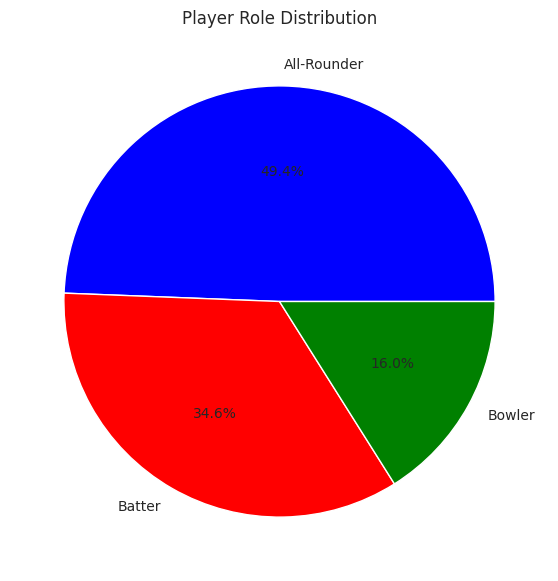

In [ ]:
import matplotlib.pyplot as plt

# Count of Each Role
role_counts = df_allrounders["predicted_role"].value_counts()

# Plot Pie Chart
plt.figure(figsize=(7,7))
plt.pie(role_counts, labels=role_counts.index, autopct="%1.1f%%", colors=['blue', 'red', 'green'])
plt.title("Player Role Distribution")
plt.show()


<ipython-input-39-b41c74b496a4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="player", y="allrounder_score", data=top_allrounders, palette="coolwarm")


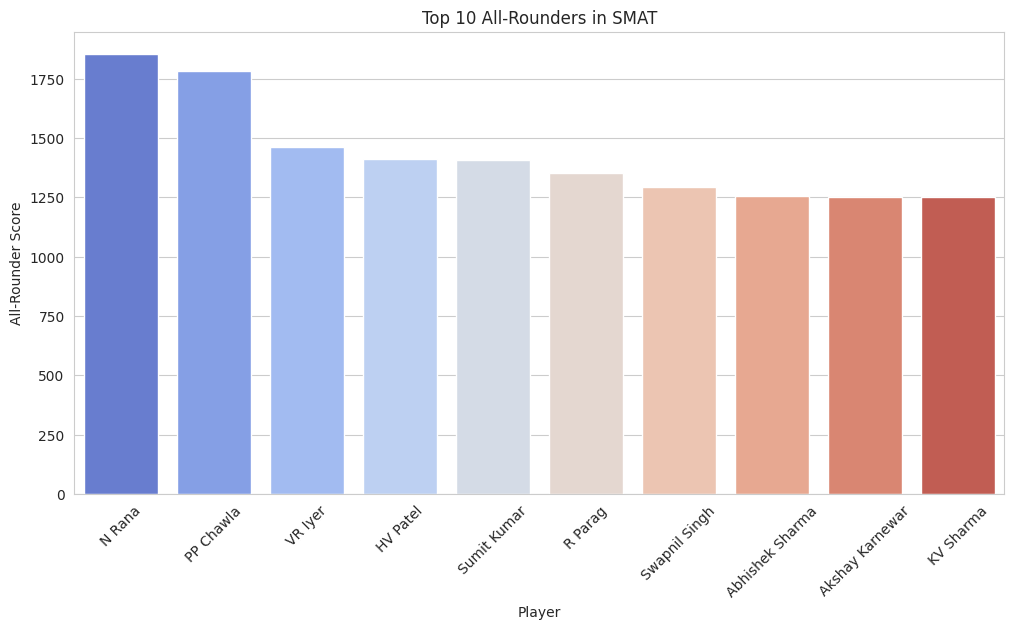

In [ ]:
import seaborn as sns

# Filter Only All-Rounders
allrounders = df_allrounders[df_allrounders["predicted_role"] == "All-Rounder"]

# Sort by All-Rounder Score
top_allrounders = allrounders.sort_values(by="allrounder_score", ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="player", y="allrounder_score", data=top_allrounders, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("All-Rounder Score")
plt.title("Top 10 All-Rounders in SMAT")
plt.show()


In [ ]:
# Step 1: Select Best Wicketkeeper (Highest Runs + Strike Rate)
wicketkeepers = ["Ishan Kishan", "Jitesh Sharma", "Dinesh Karthik", "Sanju Samson", "Rishabh Pant"]
wk_batter = df_allrounders[df_allrounders["player"].isin(wicketkeepers)] \
                .sort_values(by=["total_runs", "strike_rate"], ascending=[False, False]) \
                .head(1)

# Step 2: Select 3 More Best Batters
best_batters = df_allrounders[df_allrounders["predicted_role"] == "Batter"] \
                .sort_values(by=["total_runs", "strike_rate"], ascending=[False, False]) \
                .head(3)

# Step 3: Select 3 Best All-Rounders
best_allrounders = df_allrounders[df_allrounders["predicted_role"] == "All-Rounder"] \
                    .sort_values(by="allrounder_score", ascending=False) \
                    .head(3)

# Step 4: Select 2 Best Specialist Spinners
best_spinners = df_allrounders[(df_allrounders["predicted_role"] == "Bowler") & (df_allrounders["economy"] < 7)] \
                .sort_values(by=["total_wickets", "economy"], ascending=[False, True]) \
                .head(2)

# Step 5: Select 2 Best Fast Bowlers (Highest Wickets + Economy)
best_fast_bowlers = df_allrounders[(df_allrounders["predicted_role"] == "Bowler") & (df_allrounders["economy"] >= 7)] \
                    .sort_values(by=["total_wickets", "economy"], ascending=[False, True]) \
                    .head(2)

# Combine Best XI
best_xi = pd.concat([wk_batter, best_batters, best_allrounders, best_spinners, best_fast_bowlers]).drop_duplicates()

# Display Best XI
print("🔥 Best XI Players with Wicketkeeper, 2 Spinners, and 2 Fast Bowlers 🔥")
print(best_xi[["player", "predicted_role", "total_runs", "strike_rate", "total_wickets", "economy", "allrounder_score"]])


🔥 Best XI Players with Wicketkeeper, 2 Spinners, and 2 Fast Bowlers 🔥
          player predicted_role  total_runs  strike_rate  total_wickets  \
628  Sachin Baby         Batter        1111   130.093677              6   
195     DJ Hooda         Batter         858   131.595092              9   
725      T Kohli         Batter         812   108.701473             10   
420       N Rana    All-Rounder        1376   141.128205             24   
463    PP Chawla    All-Rounder         364   130.000000             71   
765      VR Iyer    All-Rounder         901   133.679525             28   
273   JD Unadkat         Bowler         282   154.098361             77   
9        A Sheth         Bowler         215   123.563218             67   

      economy  allrounder_score  
628  1.216981              1231  
195  1.194139              1038  
725  1.625514              1012  
420  1.057971              1856  
463  1.050050              1784  
765  1.139583              1461  
273  1.078675   

In [ ]:
# Step 1: Select Best Wicketkeeper (Replaces One Batter)
wicketkeepers = ["Ishan Kishan", "Jitesh Sharma", "Dinesh Karthik", "Sanju Samson", "Rishabh Pant"]
wk_batter = df_allrounders[df_allrounders["player"].isin(wicketkeepers)] \
                .sort_values(by=["total_runs", "strike_rate"], ascending=[False, False]) \
                .head(1)

# Remove One Batter to Fit WK
best_batters = df_allrounders[df_allrounders["predicted_role"] == "Batter"] \
                .sort_values(by=["total_runs", "strike_rate"], ascending=[False, False]) \
                .head(3)  # Reduce batters from 4 to 3 to add WK

# Step 2: Keep the Best 3 All-Rounders
best_allrounders = df_allrounders[df_allrounders["predicted_role"] == "All-Rounder"] \
                    .sort_values(by="allrounder_score", ascending=False) \
                    .head(3)

# Step 3: Select 2 Specialist Spinners
best_spinners = df_allrounders[(df_allrounders["predicted_role"] == "Bowler") & (df_allrounders["economy"] < 7)] \
                .sort_values(by=["total_wickets", "economy"], ascending=[False, True]) \
                .head(2)  # Ensures 2 spinners in XI

# Step 4: Select 3 Best Fast Bowlers
best_fast_bowlers = df_allrounders[(df_allrounders["predicted_role"] == "Bowler") & (df_allrounders["economy"] >= 7)] \
                    .sort_values(by=["total_wickets", "economy"], ascending=[False, True]) \
                    .head(3)  # Keeps 3 Pacers

# Combine Final Best XI
best_xi = pd.concat([wk_batter, best_batters, best_allrounders, best_spinners, best_fast_bowlers]).drop_duplicates()

# Display Final Best XI
print("🔥 Final Best XI with WK, 2 Spinners, & 3 Pacers 🔥")
print(best_xi[["player", "predicted_role", "total_runs", "strike_rate", "total_wickets", "economy", "allrounder_score"]])


🔥 Final Best XI with WK, 2 Spinners, & 3 Pacers 🔥
          player predicted_role  total_runs  strike_rate  total_wickets  \
628  Sachin Baby         Batter        1111   130.093677              6   
195     DJ Hooda         Batter         858   131.595092              9   
725      T Kohli         Batter         812   108.701473             10   
420       N Rana    All-Rounder        1376   141.128205             24   
463    PP Chawla    All-Rounder         364   130.000000             71   
765      VR Iyer    All-Rounder         901   133.679525             28   
273   JD Unadkat         Bowler         282   154.098361             77   
9        A Sheth         Bowler         215   123.563218             67   

      economy  allrounder_score  
628  1.216981              1231  
195  1.194139              1038  
725  1.625514              1012  
420  1.057971              1856  
463  1.050050              1784  
765  1.139583              1461  
273  1.078675              1822  
9 